In [61]:
import tensorflow as tf
import keras
from tensorflow import keras
from keras.layers import Conv2D, BatchNormalization, Dropout, ReLU, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.applications import MobileNet
import matplotlib
import sklearn
import random


In [51]:
# Print versions of TensorFlow and other libraries
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Scikit-learn version:", sklearn.__version__)

TensorFlow version: 2.15.0
NumPy version: 1.25.2
Matplotlib version: 3.7.1
Scikit-learn version: 1.2.2


In [47]:
# Set random seeds for TensorFlow, NumPy, and Python's random module
SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
data_dir = '/content/drive/MyDrive/dataset'

In [64]:
batch_size = 32
img_height = 224 # I changed the size of the dataset to fit the model
img_width = 224
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1400 files belonging to 4 classes.
Using 1120 files for training.


In [65]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1400 files belonging to 4 classes.
Using 280 files for validation.


In [30]:
class_names = train_ds.class_names
print(class_names)

['bear', 'elephant', 'leopard', 'zebra']


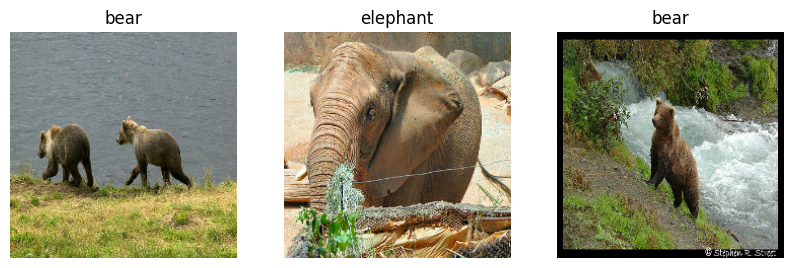

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [66]:
preprocess_input = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescale pixel values to [0, 1]

])
train_ds = train_ds.map( lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map( lambda x, y: (preprocess_input(x), y))

In [67]:
#Method for plotting models
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,5.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()


**Baseline model VGG16**

In training with the VGG16 model with no pretrained weights, the accuracy values for both training and validation are quite low and show little improvement throughout the epochs. This suggests that the model is not learning effectively from the training data. It seems like the model is inadequate.


In [8]:
def vgg_train_model(train_ds, val_ds, epochs):
    # Define the model architecture
    vgg_model = VGG16(weights=None, include_top=True, input_shape=(224, 224, 3))

    # Compile the model
    vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = vgg_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    return history

In [ ]:
# Call the function to train the model
vgg_model = vgg_train_model(train_ds, val_ds, epochs=20)

Epoch 1/20
35/35 [==============================] - 24s 530ms/step - loss: 3.1858 - accuracy: 0.2607 - val_loss: 1.3898 - val_accuracy: 0.3036
Epoch 2/20
35/35 [==============================] - 18s 478ms/step - loss: 1.4135 - accuracy: 0.2661 - val_loss: 1.3993 - val_accuracy: 0.2464
Epoch 3/20
35/35 [==============================] - 19s 503ms/step - loss: 1.4032 - accuracy: 0.2455 - val_loss: 1.3940 - val_accuracy: 0.2179
Epoch 4/20
35/35 [==============================] - 18s 476ms/step - loss: 1.3997 - accuracy: 0.2723 - val_loss: 1.4083 - val_accuracy: 0.2321
Epoch 5/20
35/35 [==============================] - 18s 478ms/step - loss: 1.4209 - accuracy: 0.2518 - val_loss: 1.4243 - val_accuracy: 0.2321
Epoch 6/20
35/35 [==============================] - 18s 483ms/step - loss: 1.4104 - accuracy: 0.2500 - val_loss: 1.3874 - val_accuracy: 0.3036
Epoch 7/20
35/35 [==============================] - 18s 495ms/step - loss: 1.4145 - accuracy: 0.2223 - val_loss: 1.3909 - val_accuracy: 0.3036

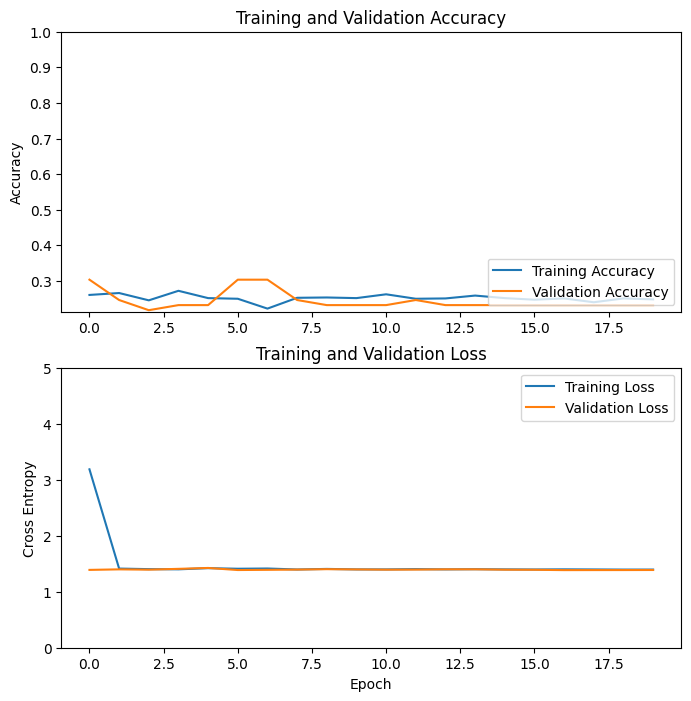

In [ ]:
plot_training(vgg_model)

**Using a different architecture ResNet50**

ResNet50 typically outperforms VGG16 due to its deeper architecture with skip connections, which help alleviate the vanishing gradient problem and facilitate training of deeper networks. Additionally, ResNet50's skip connections enable more efficient information flow during training, leading to improved performance, especially on complex tasks and datasets.

After using ResNet50 model with no pretrained weights, I observe better accuracy results and an increase in accuracy values. This model is more effective than baseline model.
However, the model's accuracy goes up and down during training and validation.Initially, both training and validation accuracies rise, indicating learning; however, the training accuracy continues to increase, while the validation accuracy does not reach the same high values as the training accuracy, indicating a gap between them. This implies that the model is fitting to the training data, resulting in reduced generalization capability on unseen data.

In [ ]:
def resnet_train_model(train_ds, val_ds, epochs):
    # Define the model architecture
    resnet_model = ResNet50(weights=None, include_top=True, input_shape=(224, 224, 3))

    # Compile the model
    resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    return history

# Call the function to train the model
history = resnet_train_model(train_ds, val_ds, epochs=20)

Epoch 1/20
35/35 [==============================] - 50s 436ms/step - loss: 1.5990 - accuracy: 0.4920 - val_loss: 3.7547 - val_accuracy: 0.2179
Epoch 2/20
35/35 [==============================] - 15s 399ms/step - loss: 0.8256 - accuracy: 0.6893 - val_loss: 2.8596 - val_accuracy: 0.2179
Epoch 3/20
35/35 [==============================] - 15s 388ms/step - loss: 0.7150 - accuracy: 0.7295 - val_loss: 3.1352 - val_accuracy: 0.2179
Epoch 4/20
35/35 [==============================] - 15s 415ms/step - loss: 0.5815 - accuracy: 0.8000 - val_loss: 2.8762 - val_accuracy: 0.2750
Epoch 5/20
35/35 [==============================] - 15s 388ms/step - loss: 0.5640 - accuracy: 0.7830 - val_loss: 1.5493 - val_accuracy: 0.2179
Epoch 6/20
35/35 [==============================] - 15s 403ms/step - loss: 0.5028 - accuracy: 0.8196 - val_loss: 2.1103 - val_accuracy: 0.3107
Epoch 7/20
35/35 [==============================] - 14s 374ms/step - loss: 0.4921 - accuracy: 0.8259 - val_loss: 2.6022 - val_accuracy: 0.3107

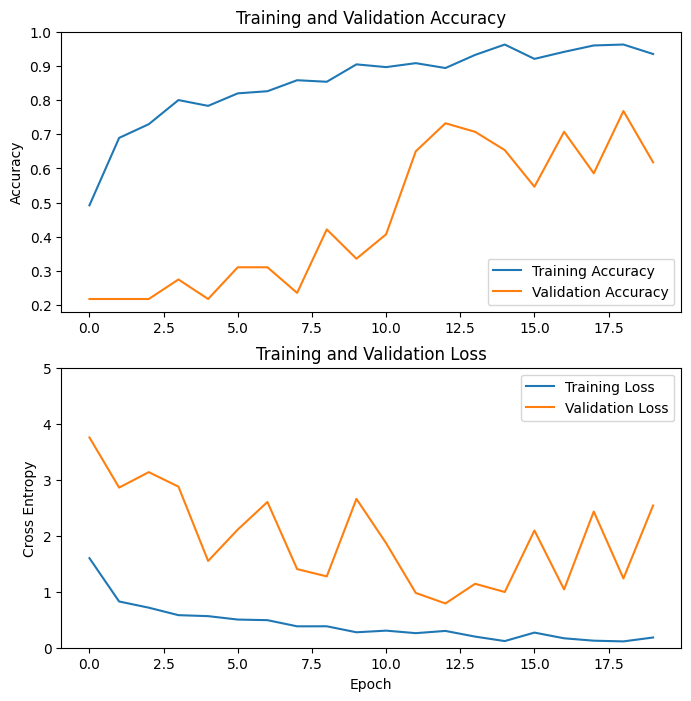

In [ ]:
resnet_model = history
plot_training(resnet_model)

**Transfer learning**

Transfer learning involves leveraging knowledge gained from pre-trained models on large datasets and applying it to new tasks or datasets, thereby accelerating model training, improving performance, and reducing the need for extensive labeled data.

This model consistently improves its accuracy and reduces its loss across epochs, suggesting effective learning and generalization. Both training and validation accuracies increase over time, indicating that the model learns from the data and generalizes well to unseen samples.


In [68]:
vgg_transfer_learning_model = tf.keras.applications.VGG16(
    include_top=True,
    weights='imagenet',
)

In [69]:
# Freeze model weights
vgg_transfer_learning_model.trainable = False

In [ ]:
vgg_transfer_learning_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [70]:
C=4
# Modify the fully connected layers
x = vgg_transfer_learning_model.layers[-2].output
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Activation('relu')(x)
output = tf.keras.layers.Dense(C, activation='softmax')(x)  # Assuming C is the number of classes

# Create a new model with modified fully connected layers
transfer_learning_model = tf.keras.Model(inputs=vgg_transfer_learning_model.input, outputs=output)

In [ ]:
transfer_learning_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [40]:
transfer_learning_model.compile(
  optimizer='adam',
  loss= 'sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [41]:
transfer_learning = transfer_learning_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
35/35 [==============================] - 27s 446ms/step - loss: 1.4108 - accuracy: 0.5652 - val_loss: 0.5596 - val_accuracy: 0.8179
Epoch 2/20
35/35 [==============================] - 10s 254ms/step - loss: 0.4723 - accuracy: 0.8634 - val_loss: 0.3992 - val_accuracy: 0.8857
Epoch 3/20
35/35 [==============================] - 11s 298ms/step - loss: 0.3769 - accuracy: 0.8741 - val_loss: 0.3536 - val_accuracy: 0.8929
Epoch 4/20
35/35 [==============================] - 9s 221ms/step - loss: 0.2950 - accuracy: 0.9045 - val_loss: 0.2715 - val_accuracy: 0.9179
Epoch 5/20
35/35 [==============================] - 9s 220ms/step - loss: 0.2595 - accuracy: 0.9161 - val_loss: 0.3935 - val_accuracy: 0.8429
Epoch 6/20
35/35 [==============================] - 10s 264ms/step - loss: 0.2757 - accuracy: 0.9036 - val_loss: 0.2452 - val_accuracy: 0.9107
Epoch 7/20
35/35 [==============================] - 11s 301ms/step - loss: 0.2414 - accuracy: 0.9152 - val_loss: 0.2526 - val_accuracy: 0.9179
E

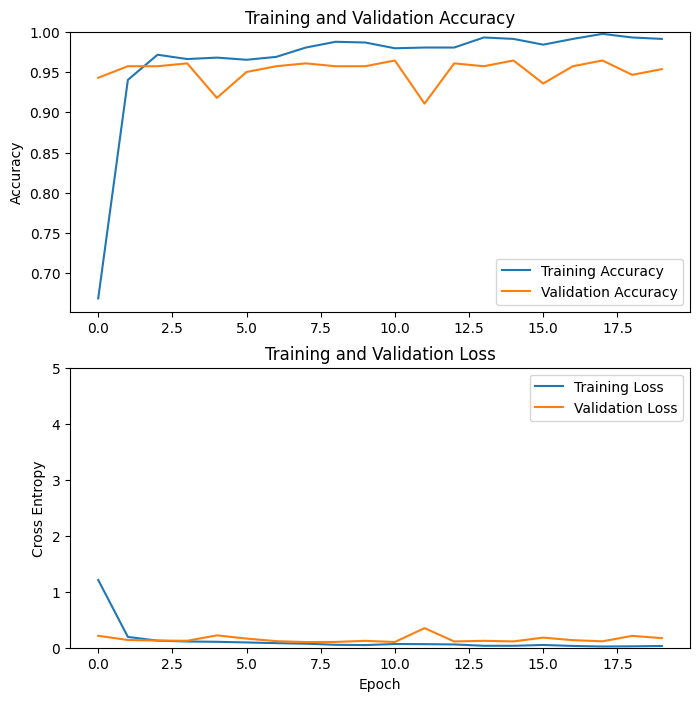

In [ ]:
plot_training(transfer_learning)

**Regularization**

Regularization may improve performance by preventing overfitting through techniques like dropout, which randomly deactivates neurons during training, forcing the model to learn more robust features and reducing reliance on individual neurons.

The regularization didn't have much effect, which might be because the validation and training accuracies are very close in the baseline model, and their values are low. Regularization techniques are mainly used to prevent overfitting by penalizing large parameter values or reducing model complexity. Since the model's accuracy level wasn't very high and there was no overfitting, regularization didn't contribute much. However, in cases where overfitting could be an issue and the accuracy is high, using regularization would make sense.

In [ ]:
# Define the model architecture with dropout regularization
def dropout_vgg_model():
    base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
    flatten_layer = tf.keras.layers.Flatten()(base_model.output)
    dropout_layer = tf.keras.layers.Dropout(0.5)(flatten_layer)  # Dropout with a dropout rate of 0.5
    output_layer = tf.keras.layers.Dense(10, activation='softmax')(dropout_layer)
    model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)
    return model

In [ ]:
def train_regularization_model(train_ds, val_ds, epochs):
    # Create VGG model with dropout regularization
    vgg_model = dropout_vgg_model()

    # Compile the model
    vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = vgg_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    return history

# Call the function to train the model
vgg_model_regularization = train_regularization_model(train_ds, val_ds, epochs=20)

Epoch 1/20
35/35 [==============================] - 26s 519ms/step - loss: 1.5883 - accuracy: 0.2429 - val_loss: 1.4076 - val_accuracy: 0.2464
Epoch 2/20
35/35 [==============================] - 17s 466ms/step - loss: 1.4026 - accuracy: 0.2562 - val_loss: 1.3935 - val_accuracy: 0.2321
Epoch 3/20
35/35 [==============================] - 18s 483ms/step - loss: 1.4002 - accuracy: 0.2696 - val_loss: 1.3878 - val_accuracy: 0.2321
Epoch 4/20
35/35 [==============================] - 18s 471ms/step - loss: 1.3996 - accuracy: 0.2545 - val_loss: 1.3992 - val_accuracy: 0.2321
Epoch 5/20
35/35 [==============================] - 17s 466ms/step - loss: 1.4097 - accuracy: 0.2464 - val_loss: 1.3983 - val_accuracy: 0.2321
Epoch 6/20
35/35 [==============================] - 19s 476ms/step - loss: 1.3985 - accuracy: 0.2348 - val_loss: 1.3899 - val_accuracy: 0.2321
Epoch 7/20
35/35 [==============================] - 20s 541ms/step - loss: 1.3997 - accuracy: 0.2313 - val_loss: 1.3937 - val_accuracy: 0.2321

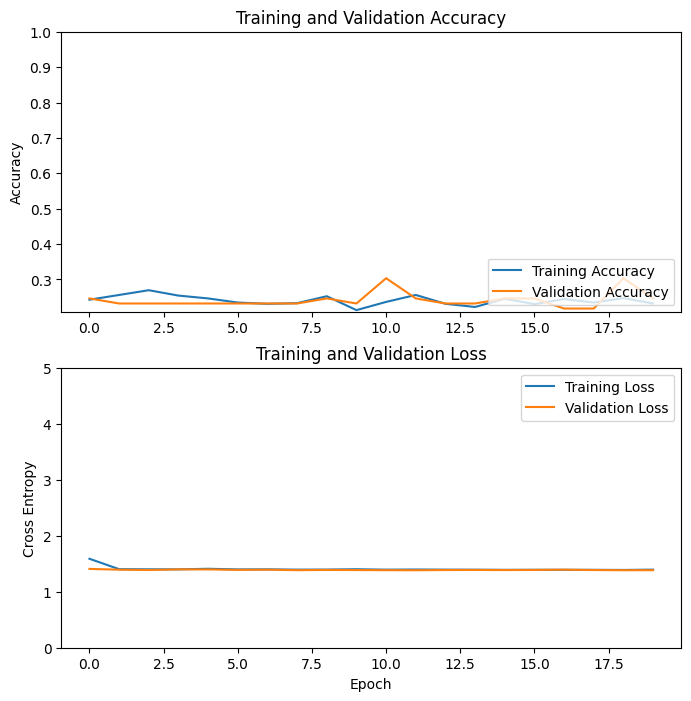

In [ ]:
plot_training(vgg_model_regularization)

**Different hyperparameter (learning rate)**

Trying different hyperparameters can impact the performance of the model because they influence how the model learns and generalizes, affecting factors such as convergence speed, model complexity, and ability to capture underlying patterns in the data.

The default learning rate value is 0.001.

*- smaller learning rate of 0.0001*

Small learning rates might enhance stability, particularly in steep or noisy optimization landscapes, and aid in converging to a more precise minimum, potentially improving generalization. In this case, it wasn't what was needed; it didn't have much effect on the model.

In [ ]:
def small_lr_train_model(train_ds, val_ds, epochs):
    # Define the model architecture
    vgg_model = VGG16(weights=None, include_top=True, input_shape=(224, 224, 3))
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    vgg_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Compile the model
    vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = vgg_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    return history

# Call the function to train the model
vgg_model = small_lr_train_model(train_ds, val_ds, epochs=20)

Epoch 1/20
35/35 [==============================] - 530s 12s/step - loss: 3.0719 - accuracy: 0.2420 - val_loss: 1.4209 - val_accuracy: 0.3036
Epoch 2/20
35/35 [==============================] - 19s 510ms/step - loss: 1.4109 - accuracy: 0.2518 - val_loss: 1.3922 - val_accuracy: 0.2464
Epoch 3/20
35/35 [==============================] - 19s 511ms/step - loss: 1.3991 - accuracy: 0.2500 - val_loss: 1.3951 - val_accuracy: 0.2179
Epoch 4/20
35/35 [==============================] - 20s 522ms/step - loss: 1.3953 - accuracy: 0.2670 - val_loss: 1.4103 - val_accuracy: 0.2321
Epoch 5/20
35/35 [==============================] - 19s 501ms/step - loss: 1.4240 - accuracy: 0.2571 - val_loss: 1.4191 - val_accuracy: 0.2321
Epoch 6/20
35/35 [==============================] - 19s 500ms/step - loss: 1.4091 - accuracy: 0.2536 - val_loss: 1.3973 - val_accuracy: 0.2464
Epoch 7/20
35/35 [==============================] - 22s 582ms/step - loss: 1.4115 - accuracy: 0.2080 - val_loss: 1.3964 - val_accuracy: 0.2321


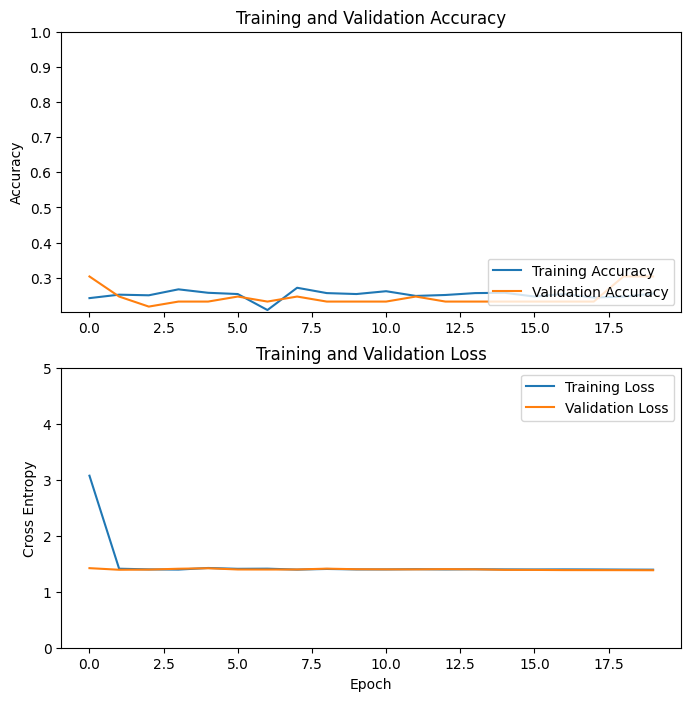

In [ ]:
plot_training(vgg_model)

*- Bigger learning rate of 0.01*

Large learning rates might accelerate convergence by amplifying the impact of parameter updates, thereby reducing the number of iterations needed for training and shortening training times.

After changing the learning rate value, considerable fluctuations in both loss and accuracy metrics are observed in the initial stages of training, as expected while the model adjusts to the dataset. However, as training progresses, a consistent decrease in both training and validation losses is observed, with a steady increase in accuracy. This trend suggests that the data is effectively learned by the model over time. This model demonstrates promising behavior.

In [ ]:
def big_lr_train_model(train_ds, val_ds, epochs):
    # Define the model architecture
    vgg_model = VGG16(weights=None, include_top=True, input_shape=(224, 224, 3))
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    vgg_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Compile the model
    vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = vgg_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    return history

# Call the function to train the model
vgg_model = big_lr_train_model(train_ds, val_ds, epochs=20)

Epoch 1/20
35/35 [==============================] - 26s 518ms/step - loss: 213.3846 - accuracy: 0.2339 - val_loss: 1.4139 - val_accuracy: 0.2464
Epoch 2/20
35/35 [==============================] - 19s 503ms/step - loss: 1.4077 - accuracy: 0.2518 - val_loss: 1.3761 - val_accuracy: 0.3714
Epoch 3/20
35/35 [==============================] - 19s 522ms/step - loss: 1.3478 - accuracy: 0.3688 - val_loss: 1.0598 - val_accuracy: 0.5000
Epoch 4/20
35/35 [==============================] - 18s 495ms/step - loss: 1.3598 - accuracy: 0.3446 - val_loss: 1.2673 - val_accuracy: 0.3893
Epoch 5/20
35/35 [==============================] - 18s 494ms/step - loss: 1.1906 - accuracy: 0.4339 - val_loss: 1.1153 - val_accuracy: 0.5000
Epoch 6/20
35/35 [==============================] - 21s 579ms/step - loss: 1.0310 - accuracy: 0.4786 - val_loss: 0.9085 - val_accuracy: 0.6071
Epoch 7/20
35/35 [==============================] - 18s 495ms/step - loss: 0.8471 - accuracy: 0.5857 - val_loss: 0.7571 - val_accuracy: 0.66

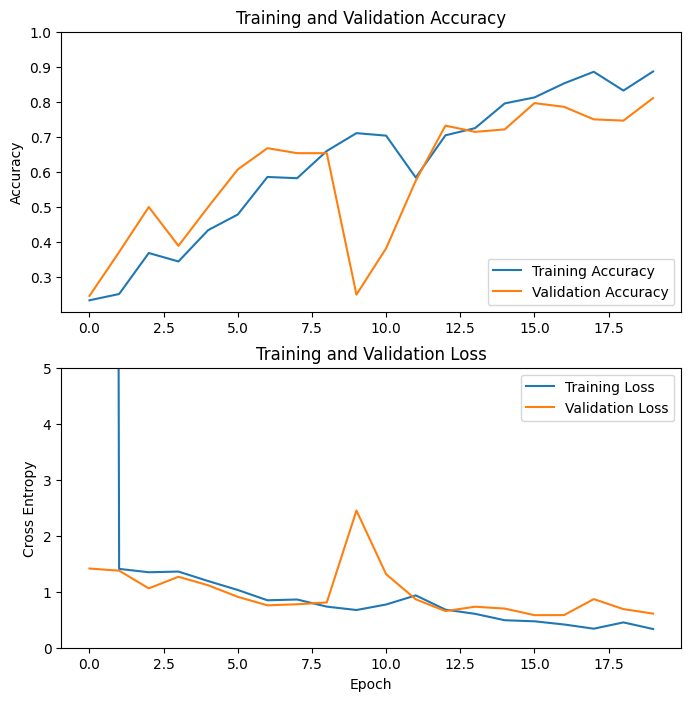

In [ ]:
plot_training(vgg_model)

**Augmentation**

The purpose of data augmentation is to increase the diversity and quantity of training data by applying various transformations, thereby enhancing the model's ability to generalize to unseen data.

Initially, significant fluctuations are observed in both loss and accuracy, indicating a period of adjustment. However, as training progresses, loss decreases, and accuracy increases, suggesting that the model is learning from the data. Overall, it can be seen that the model has indeed improved its performance, achieving higher accuracy values than baseline model.


In [71]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(5),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("vertical", seed=None)
])

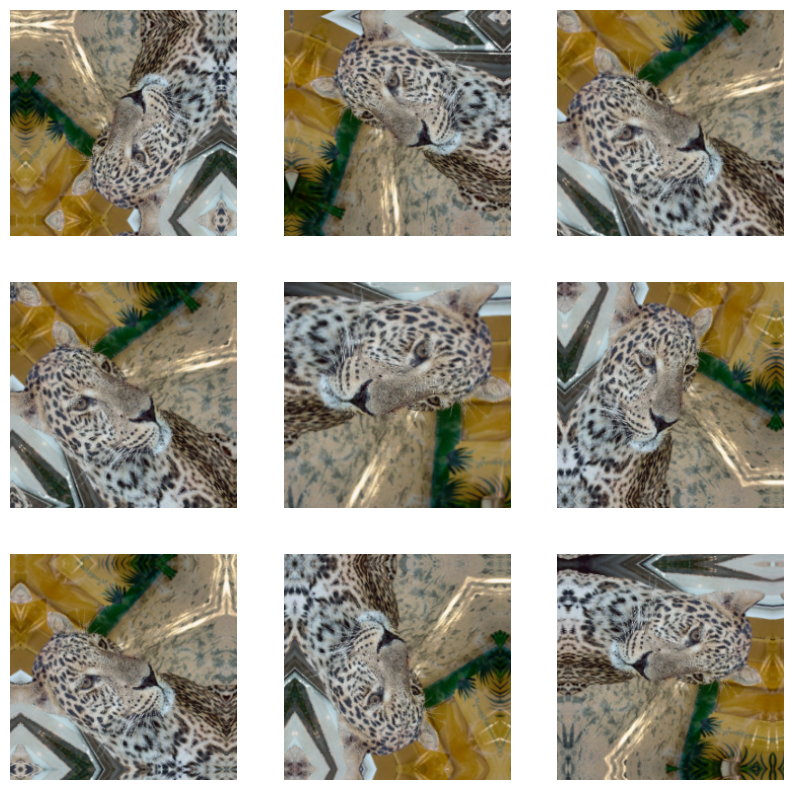

In [ ]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

In [72]:
train_ds = train_ds.map( lambda x, y: (data_augmentation(x ,training = True), y))


In [ ]:
# Train the model
vgg_model_augmentation = vgg_train_model(train_ds, val_ds, epochs=20)

Epoch 1/20
35/35 [==============================] - 231s 4s/step - loss: 58.2356 - accuracy: 0.2205 - val_loss: 1.4257 - val_accuracy: 0.3036
Epoch 2/20
35/35 [==============================] - 40s 1s/step - loss: 1.4083 - accuracy: 0.2482 - val_loss: 1.4011 - val_accuracy: 0.2464
Epoch 3/20
35/35 [==============================] - 41s 1s/step - loss: 1.4027 - accuracy: 0.2464 - val_loss: 1.3956 - val_accuracy: 0.2464
Epoch 4/20
35/35 [==============================] - 41s 1s/step - loss: 1.3946 - accuracy: 0.2607 - val_loss: 1.4135 - val_accuracy: 0.2321
Epoch 5/20
35/35 [==============================] - 40s 1s/step - loss: 1.4114 - accuracy: 0.2536 - val_loss: 1.4039 - val_accuracy: 0.2321
Epoch 6/20
35/35 [==============================] - 40s 1s/step - loss: 1.4055 - accuracy: 0.2491 - val_loss: 1.3914 - val_accuracy: 0.2464
Epoch 7/20
35/35 [==============================] - 39s 1s/step - loss: 1.3924 - accuracy: 0.2473 - val_loss: 1.2655 - val_accuracy: 0.2786
Epoch 8/20
35/35 [

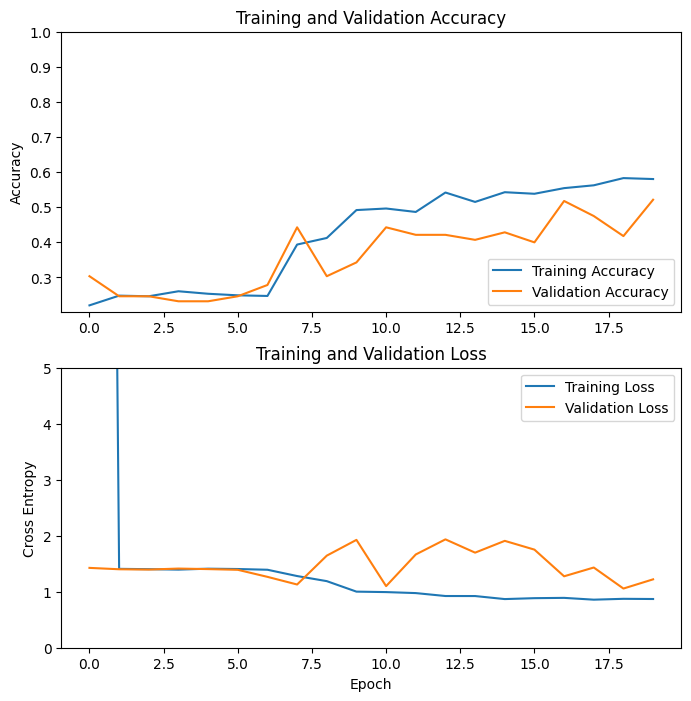

In [ ]:
plot_training(vgg_model_augmentation)

**Proposed Model**

***transfer learning VGG16 + big learning rate (0.01) + data augmentation***

I chose the augmented VGG16 model because it showed the best performance.
Although the accuracy of the VGG16 model with transfer learning is already high, there are still areas where the model can be improved.

- After noticing that the suitable learning rate for the VGG16 model is 0.01, I changed the learning rate to improve performance.

- Due to the limited number of data in the dataset and observing that augmentation also enhances performance, I applied data augmentation.

In [73]:
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

# Compile the model
transfer_learning_model.compile(
  optimizer= optimizer,
  loss= 'sparse_categorical_crossentropy',
  metrics=['accuracy']
)

# Train the model
history = transfer_learning_model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
35/35 [==============================] - 33s 692ms/step - loss: 4.6368 - accuracy: 0.8116 - val_loss: 0.3945 - val_accuracy: 0.9750
Epoch 2/20
35/35 [==============================] - 22s 607ms/step - loss: 0.4080 - accuracy: 0.9196 - val_loss: 0.0899 - val_accuracy: 0.9786
Epoch 3/20
35/35 [==============================] - 19s 523ms/step - loss: 0.2486 - accuracy: 0.9268 - val_loss: 0.0768 - val_accuracy: 0.9893
Epoch 4/20
35/35 [==============================] - 20s 548ms/step - loss: 0.2048 - accuracy: 0.9304 - val_loss: 0.1422 - val_accuracy: 0.9679
Epoch 5/20
35/35 [==============================] - 20s 533ms/step - loss: 0.1964 - accuracy: 0.9420 - val_loss: 0.0612 - val_accuracy: 0.9857
Epoch 6/20
35/35 [==============================] - 22s 611ms/step - loss: 0.1602 - accuracy: 0.9446 - val_loss: 0.0473 - val_accuracy: 0.9786
Epoch 7/20
35/35 [==============================] - 20s 528ms/step - loss: 0.2199 - accuracy: 0.9277 - val_loss: 0.0358 - val_accuracy: 0.9929

As a result,  
* The model started to converge more stable and faster compared to transfer learning applied model.
* The overall accuracy of the model increased.
* A bit more smoother graph can be observed by considering the graph of transfer learning applied model and this proposed model.
* Compared to transfer learning applied model this time validation accuracy is higher than the training accuracy.

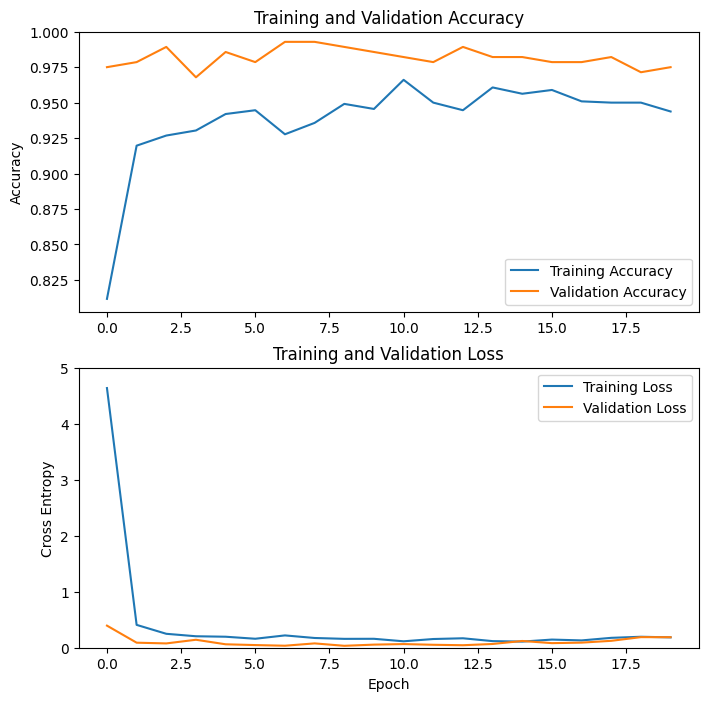

In [74]:
plot_training(history)

***transfer learning VGG16 + big learning rate (0.01) + regularization + data augmentation***

Even though the model does not seem to suffer from overfitting (the training accuracy is high, and the validation accuracy is also high), I applied regularization to see what would happen. Perhaps it can help ensure greater consistency between the training and validation accuracy.

In [43]:
# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add dropout and dense layers on top of the pre-trained model
x = Flatten()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)
# Create the combined model
combined_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
combined_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = combined_model.fit(train_ds, validation_data=val_ds, epochs=20)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
35/35 [==============================] - 12s 244ms/step - loss: 12.9364 - accuracy: 0.6295 - val_loss: 0.3401 - val_accuracy: 0.8821
Epoch 2/20
35/35 [==============================] - 9s 219ms/step - loss: 0.3841 - accuracy: 0.8518 - val_loss: 0.2010 - val_accuracy: 0.9214
Epoch 3/20
35/35 [==============================] - 11s 248ms/step - loss: 0.3016 - accuracy: 0.8920 - val_loss: 0.1903 - val_accuracy: 0.9357
Epoch 4/20
35/35 [==============================] - 11s 290ms/step - loss: 0.2129 - accuracy: 0.9187 - val_loss: 0.2333 - val_accuracy: 0.9179
Epoch 5/20
35/35 [==============================] - 9s 217ms/step - loss: 0.2417 - accuracy: 0.9152 - val_loss: 0.1986 - val_accuracy: 0.9357
Epoch 6/20
35/35 [==============================] - 10s 262ms/step - loss: 0.1955 - accuracy: 0.9277 - val_loss: 0.1844 - val_accuracy: 0.9393
Epoch 7/20
35/35 [==============================] - 11s 298ms/step - loss: 0.1

As a result,  
*  The model started to converge more stable and faster compared to transfer learning applied model. 
*  The overall accuracy of the model increased but smaller than the proposed model 1.
* The gap between validation and training accuracy is recuded compared to both transfer learning applied and proposed model 1.


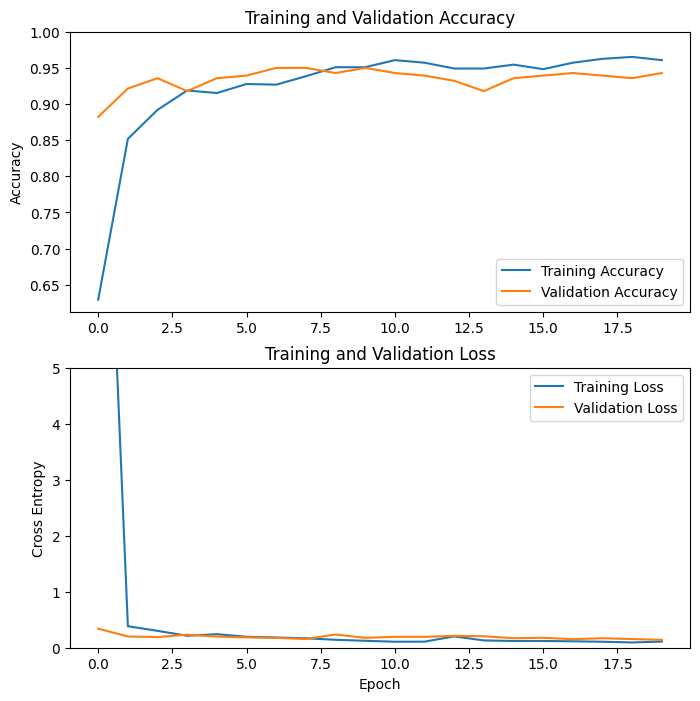

In [44]:
plot_training(history)

The second model, which includes regularization, exhibits slightly lower validation accuracy (0.9429) compared to the first model without regularization (0.9750). This suggests that while regularization may help prevent overfitting, it might also constrain the model's capacity to learn from the data, leading to slightly lower accuracy. The first model's higher validation accuracy suggests that it might have inherently been less prone to overfitting, making regularization less necessary.

Overall, I would choose the first model.
- The first model achieved a higher validation accuracy of 0.9750 compared to 0.9429 of the second model. A higher validation accuracy indicates that the first model generalizes better to unseen data.
- The first model consistently maintained high accuracy and low loss throughout the epochs, indicating stable and effective learning. In contrast, the second model showed fluctuations in accuracy and loss values.
- The combination of higher validation accuracy and lower validation loss suggests that the first model performs better in terms of both accuracy and generalization ability.
